# Creación de modelos de puntuación del Riesgo de Impago

En esta aplicación implementaremos un modelo de puntuación de riesgo de impago siguiendo la metodología  que hemos analizado en la presentación de clase (selección de variables mediante valor de la información, tramificación de variables continuas, agrupación de categorías, transformación woe de variables, estimación de modelos de regresión logística, ....)

Existen diferentes librerías que incorporan funciones con los diferentes procedimientos ya programados que nos facilitan mucho la tarea. Una de estas librerías es `scorecardpy` [librería scorecardpy](https://pypi.org/project/scorecardpy/) que estima tarjetas de puntuación *lineales* utilizando regresiones logísticas. Esta librería nació inicialmente en R, y lamentablemente la versión de Python da algunos errores de adaptación a las últimas versiones de Pandas. Su desarrollador remite a utilizar la versión estable de R (librería en R 'scorecard'). 

Así que en su lugar de esta librería utilizaremos la librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/) que en realidad recoge (y en mi opinión mejora) la principal función de la librería `scorecardpy`  

## Creación de un entorno e instalación de librerías 



In [1]:
# Podemos Crear un nuevo entorno de trabajo (mejor desde el terminal)
#! conda create -n risk_env
#! conda activate risk_env
#! conda config --env --add channels conda-forge
#! conda config --env --set channel_priority strict

# Instalamos la librería pandas y seaborn en el nuevo entrono desde conda (sólo la primera vez, utilizaré el terminal (con jupiter debo utilizar !))
# conda install pandas
# conda install seaborn

# Instalamos la librería optbinning y scorecardpy (sólo la primera vez)
# ! pip install scorecardpy # NOOO esta no la intaleis porque no es estable
# ! pip install optbinning


#Cargo o importo pandas, numpy, Matplotlib, 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para el análisis descriptivo inicial de contraste de asociación importo el test Chi2 y el anova 
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# Cargaríamos la librería scortecardpy si fuese estable (que no lo es)
#import scorecardpy as sc



# Librería para hacer la tramificación, agrupación y transformación WOE
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks


# Scikit-learn para dividir la muestra y para estimar el modelo de regresión logística (sólo si no se quiere utilizar
# la función optbinning.scorecard que ya lo incropora)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

(CVXPY) Mar 26 06:59:03 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 26 06:59:03 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


# Preparación de los datos sobre Créditos que utilizaremos en la práctica **germancredit**
## Carga de los datos 
En nuestra práctica utilizaremos una de las bases más utilizadas en los ejemplos de Puntuación de riesgo de crédito porque fue una de las primeras en ofrecerse en abierto. Corresponden a una base de datos de créditos de un Banco Alemán, y son datos reales, aunque muy antigüos de principios de los 90. Eso significa que las magnitudes de cantidades (expresadas en Marcos Alemanes), sean de difícil interpretación para el día de hoy. Sin embargo el signo y el sentido de las variables utilizadas para predecir el riesgo de impago de los futuros clientes permanece todavía de plena utilidad.

Los datos pueden descargarse del repositorio la UCI Machine Learning Repositoy [datos de Créditos alemanes](https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)). Esta base de datos está incorporada en la librería `sorecardpy` pero mejor utilizamos el fichero original `germancredit.csv` que os he preparado yo


In [2]:
# Cargamos los datos germancredit que están precargados en la librería scorecardpy
dt=pd.read_csv('germancredit.csv')

## Descripción inicial de los datos
Vamos a hacer una descripción inicial de los datos


In [3]:
#Información del Contenido
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Unnamed: 0                                                1000 non-null   int64 
 1   status.of.existing.checking.account                       1000 non-null   object
 2   duration.in.month                                         1000 non-null   int64 
 3   credit.history                                            1000 non-null   object
 4   purpose                                                   1000 non-null   object
 5   credit.amount                                             1000 non-null   int64 
 6   savings.account.and.bonds                                 1000 non-null   object
 7   present.employment.since                                  1000 non-null   object
 8   installment.rate.in.percentag

## Variable objetivo: creditability

 La variable **creditability** es la *calidad crediticia* de  cada cliente, es la variable a predecir.    
 Toma originalmente dos valores (Buen Cliente y Mal Clioente)

In [4]:
dt["creditability"].value_counts()


creditability
good    700
bad     300
Name: count, dtype: int64

In [5]:
#Recodifico esta variable creditability para que sea binaria y la llamo "y"

dt.rename(columns={"creditability":"y"},inplace=True)
dt['y'] = dt['y'].replace(['good', 'bad'], [0,1])


C:\Users\naira\AppData\Local\Temp\ipykernel_19328\3922568296.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dt['y'] = dt['y'].replace(['good', 'bad'], [0,1])


In [7]:
dt["y"].value_counts()
# No es normal que haya tantos impagos

y
0    700
1    300
Name: count, dtype: int64

In [8]:
# También elimino la primera columna que no debería estar (es una variable de identificación que no debería tener en cuenta para la estimación del modelo)
dt.drop(labels='Unnamed: 0',inplace=True, axis=1)

dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   status.of.existing.checking.account                       1000 non-null   object
 1   duration.in.month                                         1000 non-null   int64 
 2   credit.history                                            1000 non-null   object
 3   purpose                                                   1000 non-null   object
 4   credit.amount                                             1000 non-null   int64 
 5   savings.account.and.bonds                                 1000 non-null   object
 6   present.employment.since                                  1000 non-null   object
 7   installment.rate.in.percentage.of.disposable.income       1000 non-null   int64 
 8   personal.status.and.sex      

## Variables Predictoras o explicativas

Las 20 restantes variables del data frame (7 numéricas y 13 categóricas) son los atributos o características observadas de esos clientes que se utilizarán para predecir la probabilidad de que los clientes cometan un impago de sis créditos, esto es, de que sean malos clientes. La descripción de estas 20 variables es la siguiente:

In [ ]:
#  - Attribute 1: (qualitative) **Status of existing checking account o cuenta corriente** 
#   - A11 : ... < 0 DM 
#   - A12 : 0 <= ... < 200 DM 
#   - A13 : ... >= 200 DM / salary assignments for at least 1 year 
#   - A14 : no checking account 

#- Attribute 2: (numerical) **Duration in month** 
  
#  - Attribute 3: (qualitative) **Credit history**  
#     - A30 : no credits taken/ all credits paid back duly (devultos sin mora)
#     - A31 : all credits at this bank paid back duly 
#     - A32 : existing credits paid back duly till now 
#     - A33 : delay in paying off in the past 
#     - A34 : critical account/ other credits existing (not at this bank) 

# - Attribute 4: (qualitative) **Purpose** 
#     - A40 : car (new) 
#     - A41 : car (used)
#     - A42 : furniture/equipment
#     - A43 : radio/television
#     - A44 : domestic appliances
#     - A45 : repairs
#     - A46 : education
#     - A47 : (vacation - does not exist?)
#     - A48 : retraining
#     - A49 : business
#    - A410 : others 

# - Attribute 5: (numerical) **Credit amount** 
  
# - Attribute 6: (qualitative) **Savings account/bonds** 
#    - A61 : ... < 100 DM
#    - A62 : 100 <= ... < 500 DM
#    - A63 : 500 <= ... < 1000 DM
#    - A64 : .. >= 1000 DM 
#    - A65 : unknown/ no savings account 

# - Attribute 7: (qualitative) **Present employment since** 
#     - A71 : unemployed 
#     - A72 : ... < 1 year 
#     - A73 : 1 <= ... < 4 years 
#     - A74 : 4 <= ... < 7 years 
#     - A75 : .. >= 7 years 

# - Attribute 8: (numerical) **Installment rate in percentage of disposable income** 
  
#  - Attribute 9: (qualitative) **Personal status and sex** 
#     - A91 : male : divorced/separated
#     - A92 : female : divorced/separated/married
#     - A93 : male : single
#     - A94 : male : married/widowed
#     - A95 : female : single 

# - Attribute 10: (qualitative) **Other debtors / guarantors**
#    - A101 : none
#    - A102 : co-applicant
#    - A103 : guarantor 

# - Attribute 11: (numerical) **Present residence since**
  
# - Attribute 12: (qualitative) **Property**
#     - A121 : real estate
#     - A122 : if not A121 : building society savings agreement/ life insurance
#     - A123 : if not A121/A122 : car or other, not in attribute 6 
#     - A124 : unknown / no property 

# - Attribute 13: (numerical) **Age in years** 
  
# - Attribute 14: (qualitative) **Other installment plans** Otros pagos por plazos
#      - A141 : bank
#      - A142 : stores
#      - A143 : none 

# - Attribute 15: (qualitative) **Housing**
#      - A151 : rent 
#      - A152 : own
#      - A153 : for free 

# - Attribute 16: (numerical) **Number of existing credits at this bank**
  
# - Attribute 17: (qualitative) **Job**
#   - A171 : unemployed/ unskilled - non-resident
#   - A172 : unskilled - resident
#   - A173 : skilled employee / official
#   - A174 : management/ self-employed/highly qualified employee/ officer 

# - Attribute 18: (numerical) **Number of people being liable to provide maintenance for** 
  
# - Attribute 19: (qualitative) **Telephone**
#   - A191 : none
#   - A192 : yes, registered under the customers name 

# - Attribute 20: (qualitative) **foreign worker** 
#   - A201 : yes 
#   - A202 : no 



## Analisis univariante y de asociación con la variable objetivo de las **variables categóricas**


### **status.of.existing.checking.account**

In [9]:
dt['status.of.existing.checking.account'].value_counts(normalize=True,dropna=False).sort_index()

status.of.existing.checking.account
... < 0 DM                                                0.274
... >= 200 DM / salary assignments for at least 1 year    0.063
0 <= ... < 200 DM                                         0.269
no checking account                                       0.394
Name: proportion, dtype: float64

In [10]:
ctabla=pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True).round(3)
ctabla

y,0,1,All
status.of.existing.checking.account,,,
... < 0 DM,139,135,274
... >= 200 DM / salary assignments for at least 1 year,49,14,63
0 <= ... < 200 DM,164,105,269
no checking account,348,46,394
All,700,300,1000


In [11]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)
# Rechazo la hipotesis nula de independencia


5.644860555592815e-23


In [12]:
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=1).round(3)

y,0,1,All
status.of.existing.checking.account,,,
... < 0 DM,0.199,0.450,0.274
... >= 200 DM / salary assignments for at least 1 year,0.070,0.047,0.063
0 <= ... < 200 DM,0.234,0.350,0.269
no checking account,0.497,0.153,0.394


In [13]:
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=0).round(3)

y,0,1
status.of.existing.checking.account,,
... < 0 DM,0.507,0.493
... >= 200 DM / salary assignments for at least 1 year,0.778,0.222
0 <= ... < 200 DM,0.610,0.390
no checking account,0.883,0.117
All,0.700,0.300


<Axes: xlabel='status.of.existing.checking.account'>

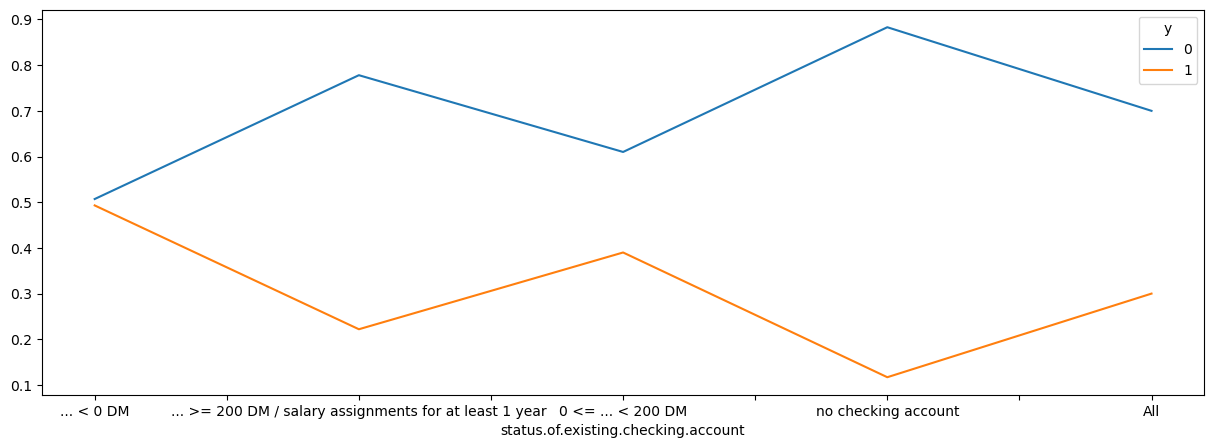

In [14]:
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))


### **Personal status and sex**

In [15]:
dt['personal.status.and.sex'].value_counts(normalize=True,dropna=False).sort_index()

personal.status.and.sex
female : divorced/separated/married    0.310
male : divorced/separated              0.050
male : married/widowed                 0.092
male : single                          0.548
Name: proportion, dtype: float64

In [16]:
ctabla=pd.crosstab(dt['personal.status.and.sex'],dt['y'],margins=True).round(3)
ctabla

y,0,1,All
personal.status.and.sex,,,
female : divorced/separated/married,221,89,310
male : divorced/separated,38,12,50
male : married/widowed,61,31,92
male : single,380,168,548
All,700,300,1000


In [17]:
pd.crosstab(dt['personal.status.and.sex'],dt['y'],margins=True, normalize=0).round(3)

y,0,1
personal.status.and.sex,,
female : divorced/separated/married,0.713,0.287
male : divorced/separated,0.760,0.240
male : married/widowed,0.663,0.337
male : single,0.693,0.307
All,0.700,0.300


In [18]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

0.9861956857599425


<Axes: xlabel='personal.status.and.sex'>

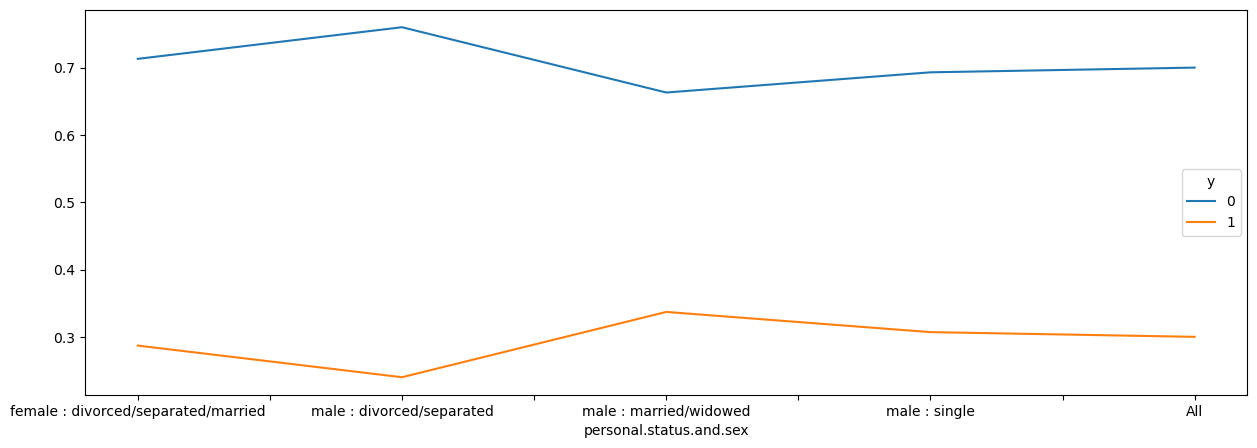

In [19]:
pd.crosstab(dt['personal.status.and.sex'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))

### **Housing**

In [20]:
dt['housing'].value_counts(normalize=True,dropna=False).sort_index()

housing
for free    0.108
own         0.713
rent        0.179
Name: proportion, dtype: float64

In [21]:
ctabla=pd.crosstab(dt['housing'],dt['y'],margins=True).round(3)
ctabla

y,0,1,All
housing,,,
for free,64,44,108
own,527,186,713
rent,109,70,179
All,700,300,1000


In [22]:
pd.crosstab(dt['housing'],dt['y'],margins=True, normalize=0).round(3)

y,0,1
housing,,
for free,0.593,0.407
own,0.739,0.261
rent,0.609,0.391
All,0.700,0.300


In [23]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

0.0057517137009144665


<Axes: xlabel='housing'>

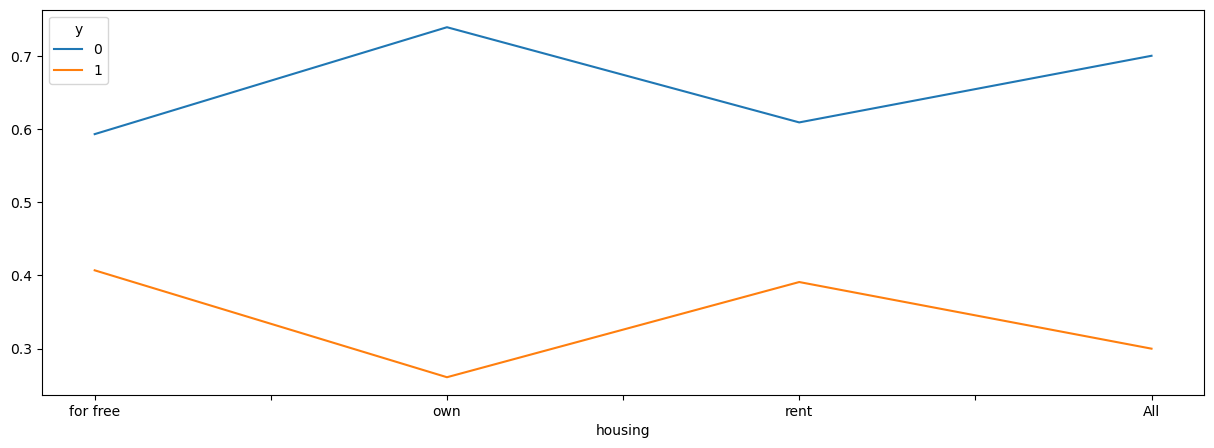

In [24]:
pd.crosstab(dt['housing'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))

### **Job**

In [25]:
dt['job'].value_counts(normalize=True,dropna=False).sort_index()

job
management/ self-employed/ highly qualified employee/ officer    0.148
skilled employee / official                                      0.630
unemployed/ unskilled - non-resident                             0.022
unskilled - resident                                             0.200
Name: proportion, dtype: float64

In [26]:
ctabla=pd.crosstab(dt['job'],dt['y'],margins=True).round(3)
ctabla

y,0,1,All
job,,,
management/ self-employed/ highly qualified employee/ officer,97,51,148
skilled employee / official,444,186,630
unemployed/ unskilled - non-resident,15,7,22
unskilled - resident,144,56,200
All,700,300,1000


In [27]:
pd.crosstab(dt['job'],dt['y'],margins=True, normalize=0).round(3)

y,0,1
job,,
management/ self-employed/ highly qualified employee/ officer,0.655,0.345
skilled employee / official,0.705,0.295
unemployed/ unskilled - non-resident,0.682,0.318
unskilled - resident,0.720,0.280
All,0.700,0.300


In [28]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

0.9843324501309928


<Axes: xlabel='job'>

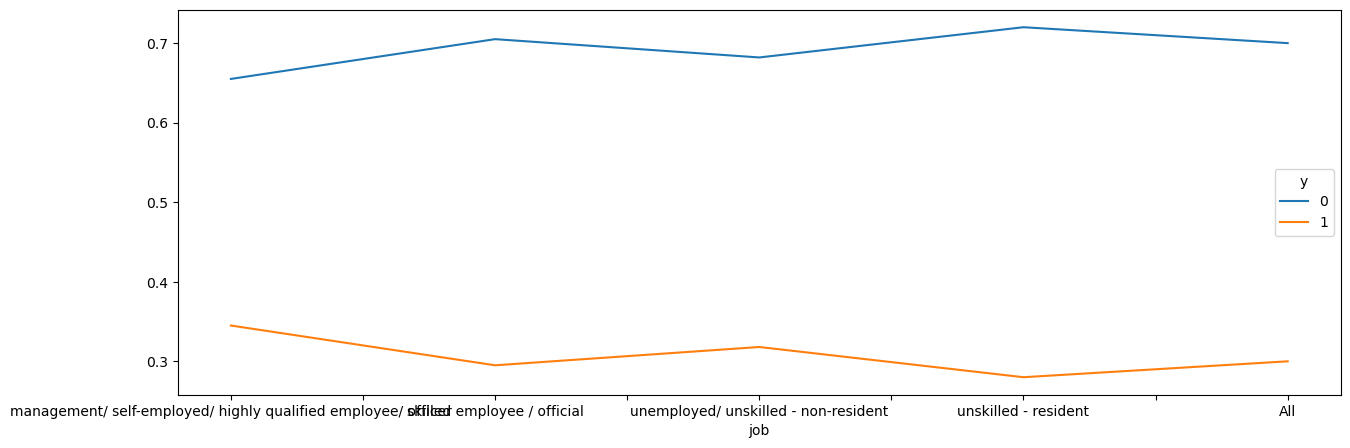

In [29]:
pd.crosstab(dt['job'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))

 ....  Habría que seguir haciendo esto con todas las variables categóricas para analizar asociación

## Analisis univariante y de asociación con la variable objetivo de las **Variables continuas**

In [30]:
dt.describe()

,duration.in.month,credit.amount,installment.rate.in.percentage.of.disposable.income,present.residence.since,age.in.years,number.of.existing.credits.at.this.bank,number.of.people.being.liable.to.provide.maintenance.for,y
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


### **Credit.amount**

c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


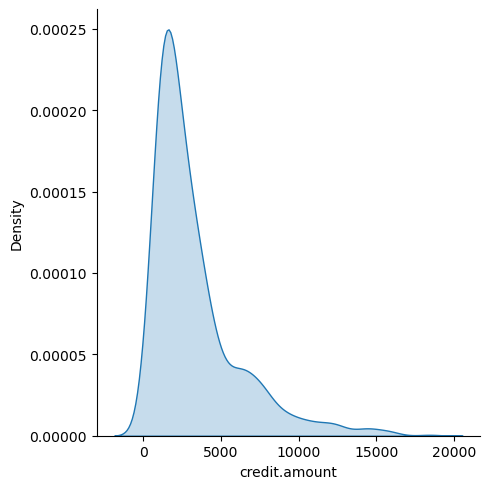

In [31]:
sns.displot(x=(dt['credit.amount']), kind="kde", fill=True)
plt.show()

c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


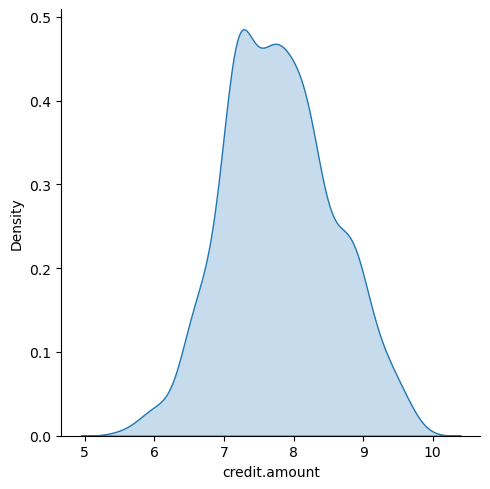

In [32]:
sns.displot(x=np.log(dt['credit.amount']), kind="kde", fill=True)
plt.show()

In [33]:
dt['credit.amount']=np.log(dt['credit.amount'])

c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


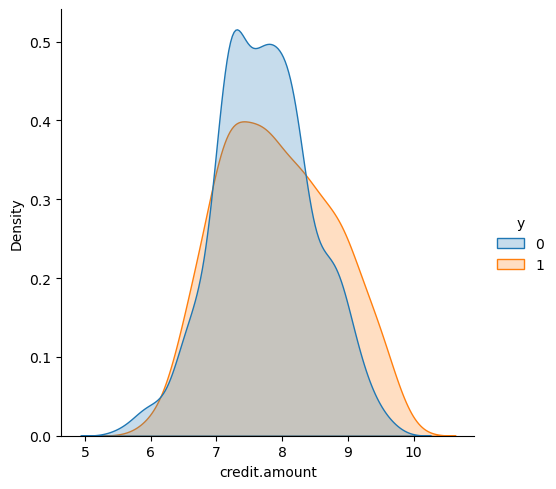

In [34]:
sns.displot(x=(dt['credit.amount']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

In [35]:
fvalue, pvalue = f_oneway(dt.loc[dt["y"]==0,['credit.amount']], dt.loc[dt["y"]==1,['credit.amount']])
print(fvalue, pvalue)


[12.12709264] [0.00051849]


### **duration.in.month**

c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


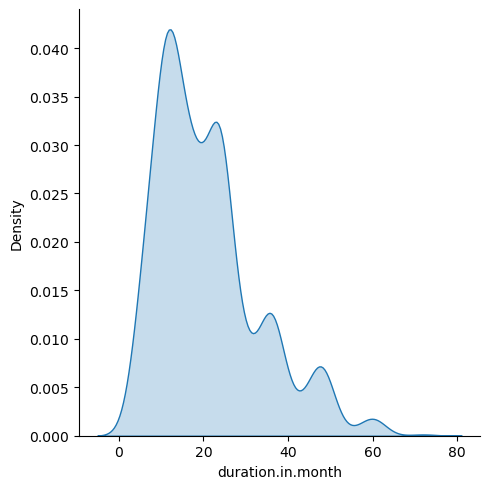

In [36]:
sns.displot(x=(dt['duration.in.month']), kind="kde", fill=True)
plt.show()

c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


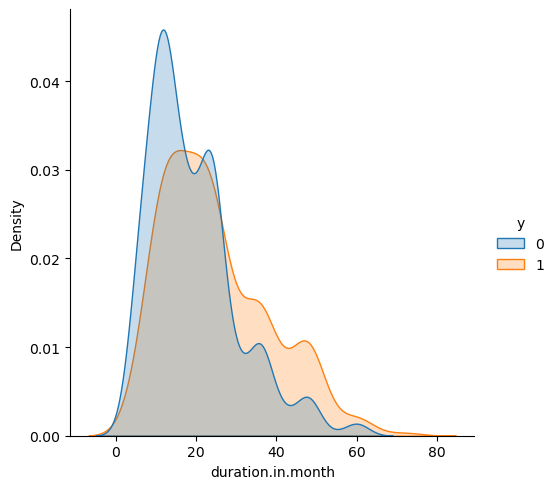

In [37]:
sns.displot(x=(dt['duration.in.month']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

In [38]:
fvalue, pvalue = f_oneway(dt.loc[dt["y"]==0,['duration.in.month']], dt.loc[dt["y"]==1,['duration.in.month']])
print(fvalue, pvalue)

[48.33379013] [6.48804988e-12]


Tendría que continuar con el análisis del resto de variables continuas .....

In [ ]:
# sns.pairplot(dt, hue="y")

# **Selección de Variables**: análisis de Concentración para seleccionar las variables más **importantes** para meter en el modelo

### Dividimos la muestra en entrenamiento y test

In [40]:
dt_train, dt_test = train_test_split(dt,stratify=dt["y"], test_size=.25, random_state=1234)
# selección que estratifique, donde se mantenga 

In [41]:
dt_train["y"].shape

(750,)

In [42]:
dt_train["y"].mean()

0.3

In [43]:
dt_test["y"].shape

(250,)

In [44]:
dt_test["y"].mean()

0.3

## Defino la tramificación óptima

## Tramificación de la Variable: "credit.amount"

In [45]:
variable="credit.amount"
X=dt_train[variable].values
Y=dt_train['y'].values

In [46]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

# Si se quisiese fijar los intervalos manualmente (porque no gusten los que obtine el agoritmo, entonces habría que usar:
#                     user_splits=
#                     user_splits_fixed=
# HAy veces que los datos tienen dátos missing y códigos especiales en este caso para obtener una categoría con esos datos missing y datos especiales hay que establecerlos
#                     special_codes = [-9, -8, -7]

# Una vez definido podemos pasar a estimarlo
optb.fit(X, Y)
optb.splits

array([6.86641216, 7.22475314, 7.31455255, 7.4804244 , 8.30634689,
       8.96692848])

Nota: Por defecto se utiliza un arbol de clasificación para hacer una tramificación inicial, y después se aplica un proceso de optimización de agrupación de categorías para maximizar el Valor de Información 

Una vez realizado el proceso de tramificación y agrupación óptima de categorías, obtenemos la tabla de agrupación 

In [47]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.87)",81,0.108000,53,28,0.345679,-0.20921,0.004915,0.000613
1,"[6.87, 7.22)",105,0.140000,71,34,0.323810,-0.110979,0.001762,0.000220
2,"[7.22, 7.31)",40,0.053333,32,8,0.200000,0.538997,0.013689,0.001691
3,"[7.31, 7.48)",47,0.062667,43,4,0.085106,1.527608,0.097961,0.011178
4,"[7.48, 8.31)",293,0.390667,222,71,0.242321,0.2927,0.031407,0.003912
5,"[8.31, 8.97)",129,0.172000,81,48,0.372093,-0.32405,0.019134,0.002381
6,"[8.97, inf)",55,0.073333,23,32,0.581818,-1.17754,0.115885,0.013703
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.284752,0.033698


Cabe mencionar que el WOE en esta tabla parece estar definido al revés que lo hemos hecho en clase, por lo que el signo es justo el contrario al que cabría esperar según lo que hemos visto en clase. En particular por defecto `optbinning` define el WOE de una categoría $i$ como
$$ WOE_i =  ln \left ( {Non-event_i \over Non-event_{total}} \over {Event_i \over Event_{total}}    \right ) $$

En este sentido los niveles con mayor tasa de impagados tendrán un WOE menos, y a medida que se reduzca la tasa de impagados (mejor calidad crediticia) irá aumentando el WOE. De hecho, 'optbinning' ni siquiera utiliza la misma fórmula que yo he utilizado en clase, por lo que no está acotada entre cero y uno, puede valos más que uno sin que eso signifique sobre ajuste.

Por talmotivo utilizaremos como criterio de selección exclusivamente IV<0.002

Podemos extraer el IV y el índice de Gini a partir de la tabla

In [48]:
print("IV= ", binning_table.iv.round(3))
print("Gini= ", binning_table.gini.round(3))

# La última columna muestra el estadístico Jensen-Shannon de divergencia.
# Es una medida de la similaridad entre dos distribuciones de probabilidad (frecuencias de buenos y malos )
# que está acotada entre 0 y log2 (aprox 0.70) (puede utilizarse 0.01 como mínimo) 
print("JS= ", binning_table.js.round(3))



IV=  0.285
Gini=  0.265
JS=  0.034


In [49]:
# Podemos profundizar en el análisis estimando otras
binning_table.analysis(pvalue_test="chi2")
 

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.26474497
    IV (Jeffrey)             0.28475238
    JS (Jensen-Shannon)      0.03369816
    Hellinger                0.03460398
    Triangular               0.12840345
    KS                       0.15746032
    HHI                      0.22561778
    HHI (normalized)         0.12882000
    Cramer's V               0.23654104
    Quality score            0.14360976

  Monotonic trend                valley

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1     0.098413 0.753743  0.622102  0.377898
        1      2     2.157938 0.141835  0.939760  0.060240
        2      3     2.398979 0.121414  0.944794  0.055206
        3      4     5.822669 0.015821  0.003026  0.996974
        4      5     7.449782 0.006344  0.003050  0.996950
        5      6     6.9

In [50]:
# Por ejemplo otra medida que suele utilizarse en el Quality score(QS) que está acotada entre 0 y 1 (puede utilizarse 0.01 como mínimo)
print("QS= ", binning_table.quality_score.round(3))

QS=  0.144


In [51]:
# La tabla anterior también muestra la V de Cramer (por encima de 0.20 podría ser suficiente para decir que hay asociación, 

# pero también podemos realizar el test con la tabla de contigencia completa:Jensen-Sha
x_transform_indices = optb.transform(X, metric="indices")

#pd.Series(x_transform_indices).value_counts(normalize=True,dropna=False).sort_index()
ctabla=pd.crosstab(pd.Series(x_transform_indices),Y,margins=True).round(3)
print(ctabla)

# Chi-square test of independence. Ho: Ausencia de Asociación (independencia)
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print("Test independencia. Estadístico :" ,round(c,3), "p-valor:", round(p,3))

col_0    0    1  All
row_0               
0       53   28   81
1       71   34  105
2       32    8   40
3       43    4   47
4      222   71  293
5       81   48  129
6       23   32   55
All    525  225  750
Test independencia. Estadístico : 41.964 p-valor: 0.0


Podemos realizar una representación gráfica de la Tabla de tramificación

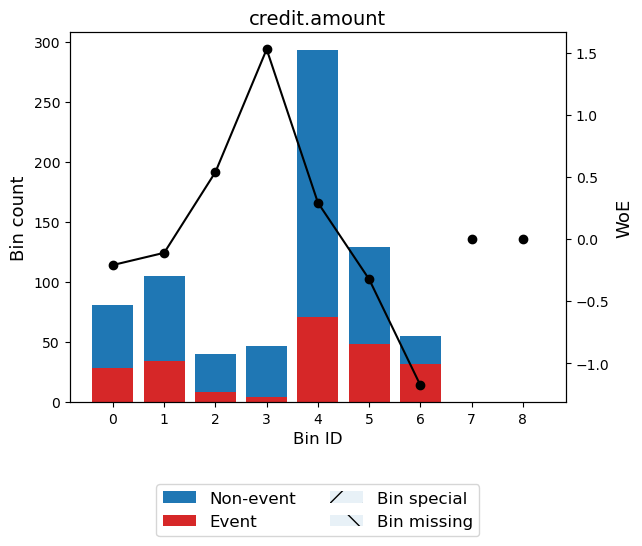

In [52]:
binning_table.plot(metric="woe")

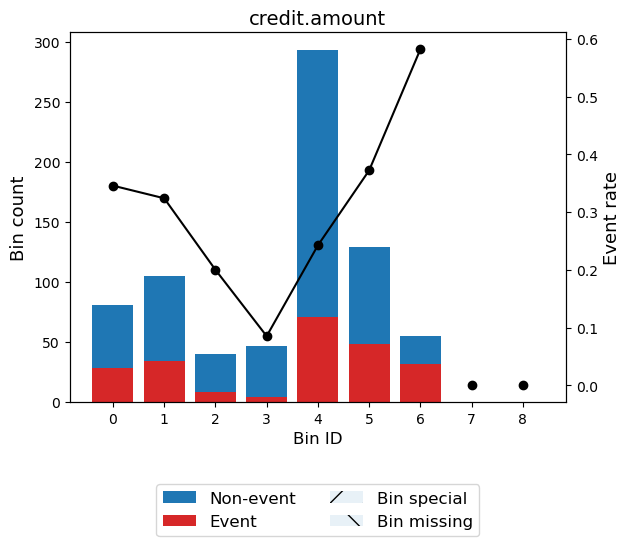

In [53]:
binning_table.plot(metric="event_rate")

Nótese que la relación entre lavariable x (credit.amount) y la tasa de evento (impago) es **no-lineal**

Ahora podemos aplicar esta tramificación óptima a la variable original y obtener la variable transformada WOE (que será una variable continua que utilizaremos en el modelode regresión)

In [54]:
# Transformación WOE
x_woe = optb.transform(X, metric="woe")
pd.Series(x_woe).value_counts().sort_index()

-1.177540     55
-0.324050    129
-0.209210     81
-0.110979    105
 0.292700    293
 0.538997     40
 1.527608     47
Name: count, dtype: int64

Fíjate que ahora hemos conseguido "linealizar" la relación entre la variable trasnformada Woe y la propensión al impago 

In [55]:
pd.crosstab(x_woe,Y,normalize=0).round(3)

col_0,0,1
row_0,,
-1.177540,0.418,0.582
-0.324050,0.628,0.372
-0.209210,0.654,0.346
-0.110979,0.676,0.324
0.292700,0.758,0.242
0.538997,0.800,0.200
1.527608,0.915,0.085


Text(0, 0.5, 'porcentaje de impago')

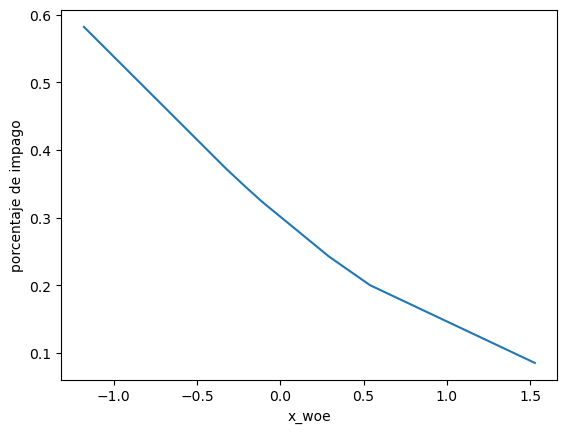

In [56]:
fig, ax = plt.subplots()
ax.plot(pd.crosstab(x_woe,Y,normalize=0).iloc[:,1])
ax.set_xlabel("x_woe")
ax.set_ylabel("porcentaje de impago")

Nótese que para hacer la validación deberíamos hacer exactamente la misma transformación WOE, con la misma tramificación, al conjunto test. Para ello debemos aplicar la transformación optima calculada con el conjunto de entrenamiento, pero sobre la muestra de validación 

In [57]:
# Transformación WOE en el conjunto test
x_test_woe = optb.transform(dt_test[variable].values, metric="woe")
pd.Series(x_test_woe).value_counts().sort_index()

-1.177540    20
-0.324050    38
-0.209210    28
-0.110979    39
 0.292700    96
 0.538997    14
 1.527608    15
Name: count, dtype: int64

Nótese que **no** estamos calculando una nueva tramificación para el conjunto de test, sino aplicando la tramificación obtenida con el conjunto de entrenamiento.    
En realidad si hiciéramos una tramificación óptima con el conjunto de test no tendría porqué salir igual que la estimada para el conunto de entrenamiento, como se puede comprobar a continuación

In [58]:
variable="credit.amount"
X_test=dt_test[variable].values
Y_test=dt_test['y'].values
optb_test = OptimalBinning(name=variable, dtype="numerical")
optb_test.fit(X_test, Y_test)
print(optb_test.splits)
binning_table_test = optb_test.binning_table
binning_table_test.build()

[6.59098554 7.06933808 7.31653738 8.8512311  9.1008029 ]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.59)",15,0.060,12,3,0.200000,0.538997,0.015400,0.001902
1,"[6.59, 7.07)",29,0.116,23,6,0.206897,0.496437,0.025531,0.003159
2,"[7.07, 7.32)",37,0.148,27,10,0.270270,0.145954,0.003058,0.000382
3,"[7.32, 8.85)",140,0.560,98,42,0.300000,0.0,0.000000,0.000000
4,"[8.85, 9.10)",15,0.060,9,6,0.400000,-0.441833,0.012624,0.001565
5,"[9.10, inf)",14,0.056,6,8,0.571429,-1.13498,0.082151,0.009751
6,Special,0,0.000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,250,1.000,175,75,0.300000,,0.138764,0.016759


Nótese que con el conjunto de test se han obtenido sólo 6 tramos y con diferentes puntos de corte ( y diferentes WOE), por eso es necesario no hacer una nueva tramificación al conjnto de test sino aplicar la tramificación obtenida usando en el conjunto de entrenamiento

## Tramificación de la duración en meses

In [59]:
variable="duration.in.month"
X=dt_train[variable].values
Y=dt_train['y'].values

optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

optb.fit(X, Y)
optb.splits

array([ 7.5, 11.5, 15.5, 34.5, 43.5])

In [60]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 7.50)",65,0.086667,59,6,0.092308,1.43848,0.123298,0.014207
1,"[7.50, 11.50)",70,0.093333,56,14,0.200000,0.538997,0.023955,0.002959
2,"[11.50, 15.50)",192,0.256000,145,47,0.244792,0.279288,0.018797,0.002342
3,"[15.50, 34.50)",293,0.390667,195,98,0.334471,-0.159266,0.010213,0.001275
4,"[34.50, 43.50)",83,0.110667,49,34,0.409639,-0.481838,0.027840,0.003447
5,"[43.50, inf)",47,0.062667,21,26,0.553191,-1.060872,0.080155,0.009574
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.284258,0.033804


In [61]:
print("IV= ", binning_table.iv.round(3))
print("Gini= ", binning_table.gini.round(3))


IV=  0.284
Gini=  0.269


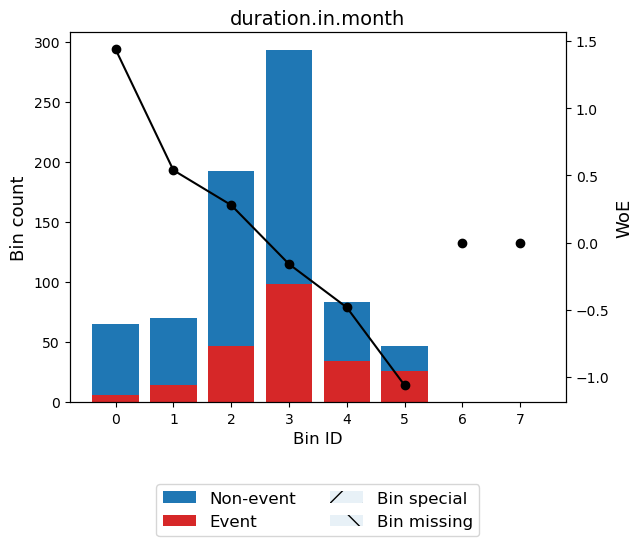

In [62]:
binning_table.plot(metric="woe")

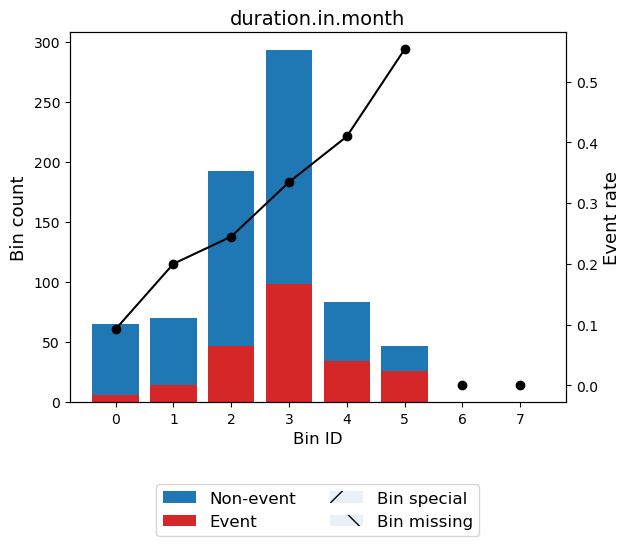

In [63]:
binning_table.plot(metric="event_rate")

In [64]:
# Transformación WOE
x_woe = optb.transform(X, metric="woe")
pd.Series(x_woe).value_counts().sort_index

<bound method Series.sort_index of -0.159266    293
 0.279288    192
-0.481838     83
 0.538997     70
 1.438480     65
-1.060872     47
Name: count, dtype: int64>

# Agrupción de niveles en variables Vbles Categóricas

En realidad, cuando tenemosvariables categóricas, no es necesario tramificar, pero sí hacer una agrupación de los diferentes niveles de forma que se maximice el *valor de información*

## Agrupación de la variable  *purpose*

In [65]:
variable_cat = "purpose"
X_cat = dt_train[variable_cat].values
Y_cat = dt_train['y'].values

dt_train[variable_cat].value_counts()

purpose
radio/television       221
car (new)              170
furniture/equipment    134
car (used)              82
business                70
education               36
repairs                 13
others                  10
domestic appliances      9
retraining               5
Name: count, dtype: int64

In [66]:

optb = OptimalBinning(name=variable_cat, dtype="categorical", solver="cp",
                      cat_cutoff=0.1)  # podemos cambiar los valores por defecto cat_cutoff=None, o, cat_cutoff=0.005

optb.fit(X_cat, Y_cat)
optb.splits

c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\optbinning\binning\preprocessing.py:34: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  cat_count = pd.value_counts(x)


[array(['car (used)'], dtype=object),
 array(['radio/television'], dtype=object),
 array(['furniture/equipment'], dtype=object),
 array(['car (new)'], dtype=object),
 array(['business', 'education', 'repairs', 'others',
        'domestic appliances', 'retraining'], dtype=object)]

In [67]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[car (used)],82,0.109333,67,15,0.182927,0.649345,0.039579,0.004862
1,[radio/television],221,0.294667,172,49,0.221719,0.408376,0.044857,0.005568
2,[furniture/equipment],134,0.178667,92,42,0.313433,-0.063179,0.000722,0.000090
3,[car (new)],170,0.226667,109,61,0.358824,-0.266824,0.016941,0.002111
4,"[business, education, repairs, others, domesti...",143,0.190667,85,58,0.405594,-0.46509,0.044590,0.005524
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.146688,0.018156


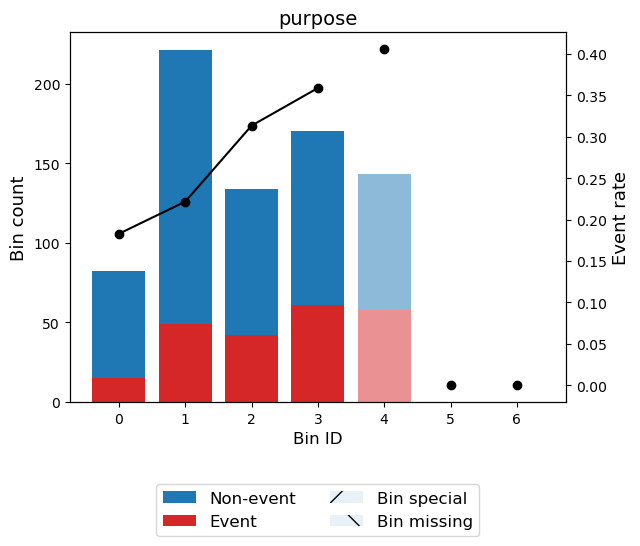

In [68]:
binning_table.plot(metric="event_rate")

In [69]:
x_woe = optb.transform(X_cat, metric="woe")
pd.Series(x_woe).value_counts()


 0.408376    221
-0.266824    170
-0.465090    143
-0.063179    134
 0.649345     82
Name: count, dtype: int64

__________________________________________________________________________________________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________________________________________________________________________________________

# Proceso de tramificación, agrupación y trasformación WOE Completo

Para no ir variable a variable se puede hacer todo el proceso completo

Proceso Entero



In [70]:
# 1) Definimos la lista de nombres señalando cualse de ellas son las categóricas
Y = dt_train['y'].values
X = dt_train.drop(columns=['y']) #todas menos la primera que es el ID y la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

In [71]:
# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02}  # no imponemos "max": 1}
}

In [72]:
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

In [73]:
# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

In [74]:
# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\optbinning\binning\preprocessing.py:34: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  cat_count = pd.value_counts(x)


In [75]:
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
19,foreign.worker,categorical,OPTIMAL,False,1,0.0,0.0,0,0.0
17,number.of.people.being.liable.to.provide.maint...,numerical,OPTIMAL,False,2,0.000027,0.000003,0.001905,0.000002
18,telephone,categorical,OPTIMAL,False,2,0.006555,0.000819,0.039365,0.011947
16,job,categorical,OPTIMAL,False,3,0.006597,0.000824,0.035564,0.002399
10,present.residence.since,numerical,OPTIMAL,False,2,0.006759,0.000843,0.026667,0.005661
15,number.of.existing.credits.at.this.bank,numerical,OPTIMAL,False,2,0.007712,0.000964,0.04254,0.014758
8,personal.status.and.sex,categorical,OPTIMAL,False,3,0.011838,0.001478,0.055467,0.009888
9,other.debtors.or.guarantors,categorical,OPTIMAL,True,2,0.025861,0.003165,0.033651,0.013879
13,other.installment.plans,categorical,OPTIMAL,True,2,0.042562,0.00529,0.08254,0.070816
7,installment.rate.in.percentage.of.disposable.i...,numerical,OPTIMAL,True,3,0.082514,0.010266,0.148301,0.143666


In [76]:
# Ahora podemos ir sacando las tablas para cada variable

dt_train_binned.get_binned_variable("credit.amount").binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.87)",81,0.108000,53,28,0.345679,-0.20921,0.004915,0.000613
1,"[6.87, 7.22)",105,0.140000,71,34,0.323810,-0.110979,0.001762,0.000220
2,"[7.22, 7.31)",40,0.053333,32,8,0.200000,0.538997,0.013689,0.001691
3,"[7.31, 7.48)",47,0.062667,43,4,0.085106,1.527608,0.097961,0.011178
4,"[7.48, 8.31)",293,0.390667,222,71,0.242321,0.2927,0.031407,0.003912
5,"[8.31, 8.97)",129,0.172000,81,48,0.372093,-0.32405,0.019134,0.002381
6,"[8.97, inf)",55,0.073333,23,32,0.581818,-1.17754,0.115885,0.013703
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.284752,0.033698


In [77]:
dt_train_binned.get_binned_variable("purpose").binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[car (used)],82,0.109333,67,15,0.182927,0.649345,0.039579,0.004862
1,[radio/television],221,0.294667,172,49,0.221719,0.408376,0.044857,0.005568
2,[furniture/equipment],134,0.178667,92,42,0.313433,-0.063179,0.000722,0.000090
3,[car (new)],170,0.226667,109,61,0.358824,-0.266824,0.016941,0.002111
4,"[business, education, repairs, others, domesti...",143,0.190667,85,58,0.405594,-0.46509,0.044590,0.005524
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.146688,0.018156


In [78]:
dt_train_binned.information()

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records                    750
    Number of variables                   20
    Target type                       binary

    Number of numerical                    7
    Number of categorical                 13
    Number of selected                    13

  Time                                1.5302 sec



In [79]:
# las variables seleccionadas se pueden obtener con 'get_support'"Tarea Estudiantes_TarjetaPuntuacion"
dt_train_binned.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True, False, False, False,
       False, False])

In [80]:
# Podemos transformar las variables WOE
dt_train_woe=dt_train_binned.transform(X, metric="woe")


# Existe la posibilidad de obtener directamente las transformada si en lugar de usar fit, hubiésemos usado fit_transform 
# dt_train_binned = binning_process.fit_transform(X, Y)
# dt_train_binned.info()
# el resultado sería un data.frame con las X seleccionadas trasnsformadas WOE



In [81]:
dt_train_woe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750 entries, 780 to 696
Data columns (total 13 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   status.of.existing.checking.account                  750 non-null    float64
 1   duration.in.month                                    750 non-null    float64
 2   credit.history                                       750 non-null    float64
 3   purpose                                              750 non-null    float64
 4   credit.amount                                        750 non-null    float64
 5   savings.account.and.bonds                            750 non-null    float64
 6   present.employment.since                             750 non-null    float64
 7   installment.rate.in.percentage.of.disposable.income  750 non-null    float64
 8   other.debtors.or.guarantors                          750 non-null    floa

In [82]:
dt_train_woe

,status.of.existing.checking.account,duration.in.month,credit.history,purpose,credit.amount,savings.account.and.bonds,present.employment.since,installment.rate.in.percentage.of.disposable.income,other.debtors.or.guarantors,property,age.in.years,other.installment.plans,housing
780,-0.336472,-0.481838,0.640779,0.408376,-0.324050,-0.213184,0.386234,0.237709,0.733153,0.380307,-0.513292,0.103678,0.200394
784,-0.336472,-0.159266,-0.107989,0.649345,-0.324050,0.664160,-0.405465,0.470943,-0.035349,0.380307,0.158722,0.103678,0.200394
698,1.117733,-0.159266,0.640779,0.408376,0.292700,-0.213184,-0.027857,-0.270514,-0.035349,-0.076961,-0.513292,0.103678,0.200394
852,1.117733,0.279288,0.640779,0.408376,0.538997,-0.213184,-0.027857,-0.270514,-0.035349,-0.574431,0.781943,0.103678,-0.552498
361,0.305382,0.279288,-0.107989,0.408376,0.292700,0.664160,0.237328,0.237709,-0.035349,-0.076961,0.474458,0.103678,0.200394
...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,-0.336472,-0.159266,-0.107989,0.408376,-0.110979,-0.213184,0.237328,-0.270514,0.733153,0.380307,-0.065203,0.103678,0.200394
584,1.117733,0.279288,-0.107989,-0.266824,0.292700,0.664160,0.237328,-0.270514,-0.035349,-0.574431,0.158722,0.103678,-0.552498
687,-0.336472,-0.481838,0.058411,-0.266824,0.292700,-0.135802,0.237328,-0.270514,-0.035349,-0.574431,-0.065203,0.103678,-0.552498
374,-0.336472,-1.060872,-1.200119,-0.465090,-1.177540,-0.135802,0.237328,0.237709,-0.035349,-0.574431,0.158722,-0.411980,-0.552498


In [83]:
# Ahora aplicaríamos la misma transformación pero al conjunto de test (si hubiera que puntuar a nuevos clientes haríamos lo mismo)

Y_test = dt_test['y'].values
X_test = dt_test.drop(columns=['y']) #todas menos la primera que es el ID y la variable y

dt_test_woe=dt_train_binned.transform(X_test, metric="woe")
dt_test_woe.info()





<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 295 to 183
Data columns (total 13 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   status.of.existing.checking.account                  250 non-null    float64
 1   duration.in.month                                    250 non-null    float64
 2   credit.history                                       250 non-null    float64
 3   purpose                                              250 non-null    float64
 4   credit.amount                                        250 non-null    float64
 5   savings.account.and.bonds                            250 non-null    float64
 6   present.employment.since                             250 non-null    float64
 7   installment.rate.in.percentage.of.disposable.income  250 non-null    float64
 8   other.debtors.or.guarantors                          250 non-null    floa

In [84]:
dt_test_woe

,status.of.existing.checking.account,duration.in.month,credit.history,purpose,credit.amount,savings.account.and.bonds,present.employment.since,installment.rate.in.percentage.of.disposable.income,other.debtors.or.guarantors,property,age.in.years,other.installment.plans,housing
295,-0.336472,-1.060872,-0.107989,-0.063179,-1.177540,-0.213184,-0.461635,0.470943,-0.035349,-0.076961,-0.070769,0.103678,0.200394
268,-0.877451,0.279288,-0.107989,-0.266824,-1.177540,-0.213184,0.237328,0.470943,-0.035349,0.138836,0.158722,0.103678,0.200394
675,1.117733,-0.159266,0.640779,0.408376,-0.324050,-0.213184,0.386234,-0.270514,-0.035349,-0.076961,-0.070769,0.103678,-0.408385
290,1.117733,0.279288,-0.107989,-0.465090,-0.110979,-0.213184,-0.027857,0.237709,-0.035349,0.380307,-0.070769,0.103678,0.200394
502,0.305382,0.538997,-0.107989,0.408376,-0.110979,-0.135802,0.237328,0.237709,-0.035349,0.380307,0.158722,0.103678,0.200394
...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,1.117733,0.279288,-0.107989,-0.266824,0.292700,0.664160,-0.027857,0.237709,-0.035349,-0.574431,-0.070769,0.103678,0.200394
265,-0.336472,0.279288,-0.107989,0.408376,-0.209210,-0.213184,0.237328,-0.270514,-0.035349,-0.076961,0.474458,0.103678,0.200394
13,-0.877451,-0.159266,0.640779,-0.266824,-0.110979,-0.213184,0.237328,-0.270514,-0.035349,-0.076961,0.158722,0.103678,0.200394
871,0.305382,1.438480,0.640779,-0.266824,-0.110979,-0.213184,0.237328,0.470943,-0.035349,0.380307,0.158722,0.103678,0.200394


# Estimación del Modelo

Ahora podemos calcular la tarjeta de puntuación. En los apuntes de clase definimos tanto los WOE, como los Odd ratio como la probabilidad de `evento` respecto al `no-evento` (malos clientes o impago=1 respecto a los buenos clientes o impago=0):

$$ odd = {{P}\over {(1-P)}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$
 
 Y la fórmula para obtener la puntuación o los score debe ser una relación negativa con los odd ratio: cuanto mayor la probabilidad de impago (en relación a la de no impago), menor puntuación ha de tener: 

 $$ score {= offset - Factor}~·~{ln(odds)}$$

Para pasar de Probabiliddes de impago a Puntuaciones, habrá que establecer tanto el valor de `offset` como el de `Factor`. Esto se hace de manera arbitraria dependiendo de cada institución financiera.

En general, para determinar estos dos valores es necesario establecer la pendiente de la recta y un punto de la misma.

En cuanto a la pendiente, cuanto más plana sea la pendiente, menor variabilidad tendrán los valores de puntuación de crédito que se alcancen, y al revés, cuanto mayor pendiente más diferencias en la puntuación final. Yo voy a utilizar un apendiente (arbitraria) estableciendo de forma arbitraria cada cuantos puntos de score (**pdo_0**) se dobla el odd ratio: $ score - pdo_0 = {offset -Factor}~ ·{ln(2*odds)}$.

 En cuanto al punto de la recta (arbitrario), puede hacerse estableciento (de manera arbitraria) la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* (**odds_0**)
 
 Así habría que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40  (esto es que cada 40 puntos de calidad creditica se dobla el odd-ratio))
* **scorecard_points** =600  (alguien con calidad crediticia muy buena, de sobresaliente, sacaría 600 puntos)
* **odds_0** =1/50  (odd ratio que se considera de sobresaliente)

La librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/), en realidad utiliza el módulo de `credit scoring` de `SAS-miner` como inspiración, y por eso define al revés tanto los WOE como los odd ratio, es decir `no-evento` en relación a `evento` (clientes buenos respecto a los malos, o no-impago respecto a impago, impago=0 respecto a impago=1). 
$$ odd^B = {{(1-P)}\over {P}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$

Esto implica que la ecuación que transforma las probabilidades de impago en scores utilizando esta *odds<sup>B</sup>* debe tener pendiente positiva (cuanto mejor *odd<sup>B</sup>* mejor calidad crediticia tiene el cliente)

 $$ score= {offset + Factor} ~·~ {ln(odds^B)}$$
 
 Nótese que ahora habrá que establecer de nuevo los puntos de score que doblan el odd ratio (**pdo_0**), y también la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* **odds_0 <sup>*B*</sup>**, con **odds_0 <sup>*B*</sup>** **= 1/odds_0**.

 Así para estimar la puntuación crediticia con `optBinning` hay que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40
* **scorecard_points** =600 
* **odds_0 <sup>*B*</sup>** = 50  (equivalente a **odds_0** =1/50 )




In [85]:

# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\optbinning\binning\preprocessing.py:34: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  cat_count = pd.value_counts(x)


Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         categorical_variables=['status.of.existing.checking.account',
                                                                'credit.history',
                                                                'purpose',
                                                                'savings.account.and.bonds',
                                                                'present.employment.since',
                                                                'personal.status.and.sex',
                                                                'other.debtors.or.guarantors',
                                                                'property',
                                                                'other.installment.plans',
                                                                'housing',
                                                                'job',
                                                                'teleph...
                                                         'other.debtors.or.guarantors',
                                                         'present.residence.since',
                                                         'property',
                                                         'age.in.years',
                                                         'other.installment.plans',
                                                         'housing',
                                                         'number.of.existing.credits.at.this.bank',
                                                         'job',
                                                         'number.of.people.being.liable.to.provide.maintenance.for',
                                                         'telephone',
                                                         'foreign.worker']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [86]:
tarjeta.information(print_level=2)

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                  pdo_odds   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                    750
    Number of variables                   20
    Target type                       binary

    Number of numerical                    7
    Number of categorical                 13
    Number of selected                    13

  Timing
    Total time                          2.09 sec
    Binning process                     1.95 sec   ( 93.23%)
    Estimator                           0.03 sec   (  1.62%

In [87]:
tarjeta.table(style="detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,status.of.existing.checking.account,0,[no checking account],301,0.401333,264,37,0.122924,1.117733,0.378255,0.044965,-0.817011,85.215972
1,status.of.existing.checking.account,1,[... >= 200 DM / salary assignments for at lea...,50,0.066667,38,12,0.240000,0.305382,0.005817,0.000724,-0.817011,46.915301
2,status.of.existing.checking.account,2,[0 <= ... < 200 DM],200,0.266667,125,75,0.375000,-0.336472,0.032045,0.003987,-0.817011,16.653243
3,status.of.existing.checking.account,3,[... < 0 DM],199,0.265333,98,101,0.507538,-0.877451,0.230087,0.027872,-0.817011,-8.852762
4,status.of.existing.checking.account,4,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.817011,32.517200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,housing,0,[own],543,0.724000,402,141,0.259669,0.200394,0.027864,0.003477,-0.431450,37.506626
1,housing,1,[rent],125,0.166667,76,49,0.392000,-0.408385,0.029819,0.003702,-0.431450,22.349220
2,housing,2,[for free],82,0.109333,47,35,0.426829,-0.552498,0.036482,0.004503,-0.431450,18.761076
3,housing,3,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.431450,32.517200


In [88]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)


0.29997

In [ ]:
# para contruir las matrices de confusión necesitamos determinar un
# **punto de corte de la probabilidad**.
# Ese punto de corte es el que me va a ayudar a realizar un pronóstico sobre los clientes:
# los malos clientes serán aquelloe para los que Prob Estimada > Prob_corte.


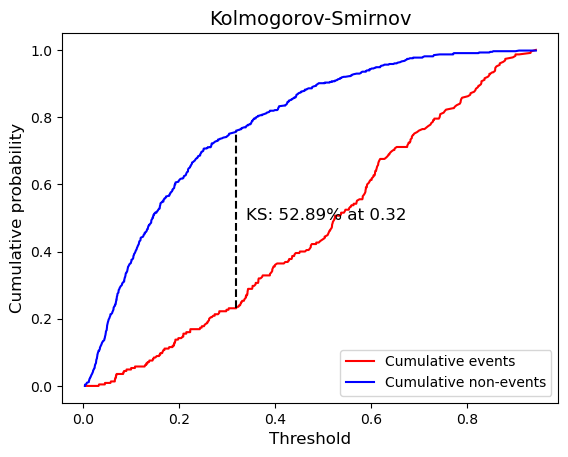

In [89]:
# Para elegir el punto de corte puede utilizarse el Plot Kolmogorov-Smirnov (KS)
plot_ks(Y, Y_pred)

El punto de corte que maximiza el f1_score es:  0.32
y el máximo se alcanza en  0.662


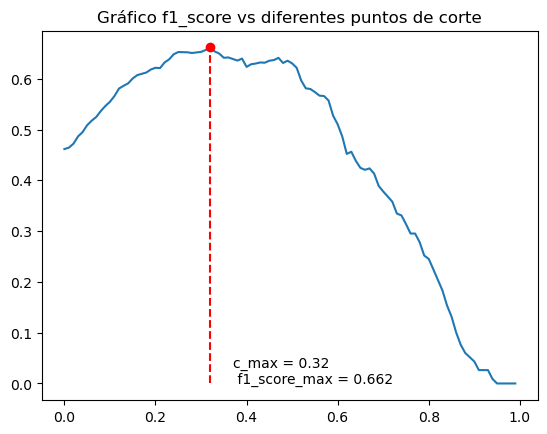

In [90]:
# También puede utilizarse el máximo del f1_score
# definimos un vector de puntos de corte
c=np.arange(0,1,0.01)
# calculamos el f1_score para cada punto de corte
f1_score_ = [f1_score(dt_train["y"],np.multiply(Y_pred>c_,1)) for c_ in c]
# obtenemos el punto de corte que maximiza el f1_score
c_max = c[np.argmax(f1_score_)]
print("El punto de corte que maximiza el f1_score es: ", c_max)
print("y el máximo se alcanza en ", np.max(f1_score_).round(3))

# hacemos un gráfico de c y los f1_score correspondientes
plt.plot(c,f1_score_)
plt.stem(c_max, np.max(f1_score_),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Gráfico f1_score vs diferentes puntos de corte")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n f1_score_max = "+str(np.max(f1_score_).round(3)))
plt.show()


El punto de corte que maximiza el índice de Youden es:  0.32
y el máximo se alcanza en  0.531


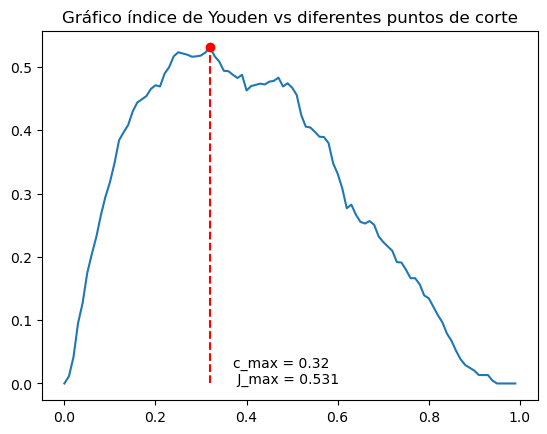

In [91]:
# método de Youden (J) para obtener el punto de corte óptimo
# definimos un vector de puntos de corte (c) y de probabilidad de aceptación (p)
c=np.arange(0,1,0.01)

# Calculamos el estadístico J de Youden para cada punto de corte= Sensibilidad + Especificidad -1
J= [balanced_accuracy_score(dt_train["y"],np.multiply(Y_pred>c_,1), adjusted=True) for c_ in c ]
# obtenemos el punto de corte que maximiza el índice de Youden
c_max = c[np.argmax(J)]
print("El punto de corte que maximiza el índice de Youden es: ", c_max)
print("y el máximo se alcanza en ", np.max(J).round(3))

# gráfico de c y los índices de Youden correspondientes
plt.plot(c,J)
plt.stem(c_max, np.max(J),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Gráfico índice de Youden vs diferentes puntos de corte")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n J_max = "+str(np.max(J).round(3)))
plt.show()

In [92]:
# Voy a utilizar simplemente la frecuencia observada
Prob_Corte=Y.mean()
print(Prob_Corte)

0.3


In [93]:
dt_train["Y_pronostico"]=np.multiply(Y_pred>Prob_Corte,1)

In [94]:
# Para comprobar la bondad de nuestras predicciones voy a comparar resultados con la tabla de confusión

# Primero estimo la precisión (los aciertos sobre el total de mis pronósticos)
pd.crosstab(dt_train["y"],dt_train["Y_pronostico"],margins=True, normalize=1).round(3)


Y_pronostico,0,1,All
y,,,
0,0.885,0.435,0.7
1,0.115,0.565,0.3


Nótese que los falsos negativos (Bad Rate) es del 11.5% (préstamos aceptados o pronosticados como buenos que resultaron impagados)

In [95]:
# Ahora estimo la exhaustividad o recall (Aciertos sobre los casos reales):
# la sensibilidad (sobre los positivos y=1), y la Especificidad (sobre los negativos y=0)

pd.crosstab(dt_train["y"],dt_train["Y_pronostico"],margins=True, normalize=0).round(3)

Y_pronostico,0,1
y,,
0,0.745,0.255
1,0.227,0.773
All,0.589,0.411


In [96]:
# Por último un resumen global de aciertos
f1_score(dt_train["y"],dt_train["Y_pronostico"])

0.6529080675422139

Para hacer la diagnosis también puedo utilizar medidas que no dependan crucialmente de un único punto de corte de Probabilidad

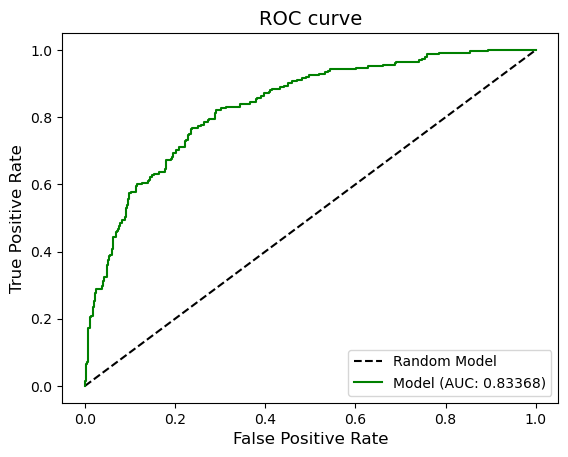

In [97]:
# Diagnosis Curva ROC
plot_auc_roc(Y,Y_pred)

In [ ]:
# Diagnosis Cumulative Accuracy Profile (CAP)
# Otra curva alternativa a la curva ROC que permite evaluar la bondad de un modelo de clasificación es la curva CAP (Cumulative Accuracy Profile).
# La curva CAP se construye de la siguiente manera: ordenamos las observaciones de mayor a menor probabilidad
# de pertenecer a la clase positiva (y=1). A continuación, vamos acumulando las observaciones y calculando
# la proporción de positivos acumulados sobre el total de positivos. Esta proporción se representa en el eje Y.

# En el eje X representamos la proporción de observaciones acumuladas sobre el total de observaciones.
# La curva CAP se construye a partir de la curva de la línea recta (curva de referencia) y 
# la curva de la línea que representa la probabilidad estimada por el modelo.

plot_cap(Y, Y_pred)

In [98]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Calculamos la media
Y_test_pred.mean().round(5)

0.32195

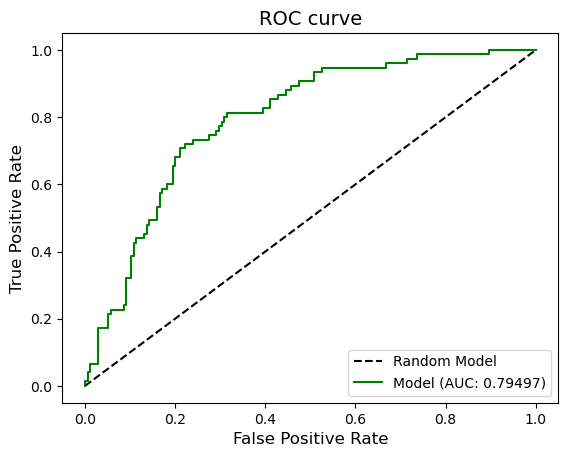

In [99]:
# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)


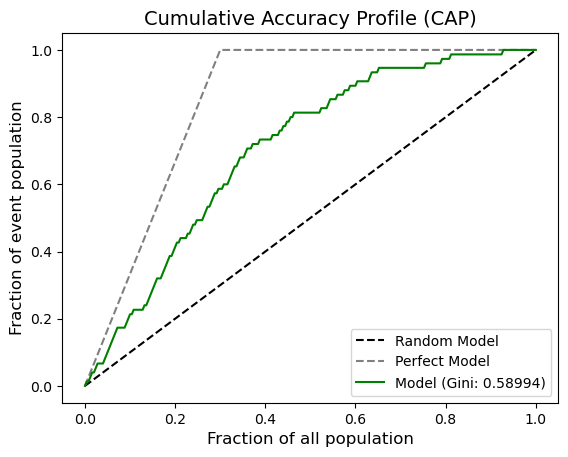

In [100]:
plot_cap(Y_test,Y_test_pred)

In [101]:
dt_test["Y_pronostico"]=np.multiply(Y_test_pred>Prob_Corte,1)

# Primero estimo la precisión (los aciertos sobre el total de mis pronósticos)
print("\n Precisión:\n", pd.crosstab(dt_test["y"],dt_test["Y_pronostico"],margins=True, normalize=1).round(3))

# Ahora estimo la exhaustividad o recall (Aciertos sobre los casos reales):
# la sensibilidad (sobre los positivos y=1), y la Especificidad (sobre los negativos y=0)
print("\n exhaustividad:\n",pd.crosstab(dt_test["y"],dt_test["Y_pronostico"],margins=True, normalize=0).round(3))

# Por último un resumen global de aciertos
print("\n f1-score:",f1_score(dt_test["y"],dt_test["Y_pronostico"]))


 Precisión:
 Y_pronostico      0      1  All
y                              
0             0.873  0.472  0.7
1             0.127  0.528  0.3

 exhaustividad:
 Y_pronostico      0      1
y                         
0             0.709  0.291
1             0.240  0.760
All           0.568  0.432

 f1-score: 0.6229508196721312


In [105]:
# Ahora vamos a calcular los score o puntuaciones.
#Que podemos hacer  con la función score
score = tarjeta.score(X)

print("Puntuación mínima: ", score.min().round(2))
print("Puntuación máxima: ",score.max().round(2))
print("Puntuación media : ",score.mean().round(2))  


# Transformación lineal según apuntes
# Factor= (pdo_0/log(2))
# Offset = scorecard_points_0+(pdo_0/log(2))*log(odds0_0)
# score= Offset - Factor *log(odds)

Factor= (pdo_0/np.log(2))
Offset = scorecard_points_0+Factor*np.log(1/odds_0_B)

#Podríamos haber calculado la puntuación también manualmente
score2= Offset-Factor*np.log(Y_pred/(1-Y_pred))

# Podemos comprobar que los resultados son los mismos   
print("Puntuación mínima: ",score2.min().round(2))
print("Puntuación máxima: ",score2.max().round(2))
print("Puntuación media : ",score2.mean().round(2))

datos_score=pd.DataFrame(np.transpose([score,score2, Y,Y_pred]), columns=['score','scoreManual','Y','Y_pred'])

# datos_score.to_excel("score_p1.xlsx")


Puntuación mínima:  211.39
Puntuación máxima:  701.43
Puntuación media :  444.05
Puntuación mínima:  211.39
Puntuación máxima:  701.43
Puntuación media :  444.05


Saber cómo se hace la transformación manual puede ayudarnos por ejemplo a la hora de establecer la `nota que determina el aprobado`. Imaginemos que utilizamos la frecuencia observada de impagos como probabilidad de corte 

In [106]:

Score_Corte= Offset-Factor*np.log(Prob_Corte/(1-Prob_Corte))

print("La probabilida de corte de: ", Prob_Corte, " equivale a una puntuación de corte de: ", Score_Corte.round(2) )


La probabilida de corte de:  0.3  equivale a una puntuación de corte de:  423.14


c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


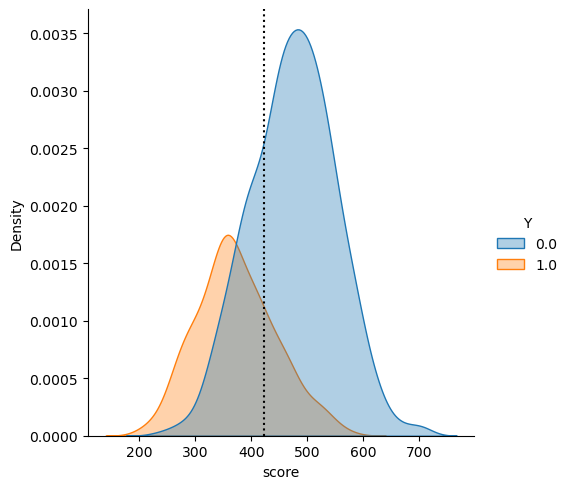

In [107]:
# Ahora representamos en un gráfico cómo separa el modelo a los buenos y los malos
datos_score=pd.DataFrame(np.transpose([score,Y]), columns=['score','Y'])
sns.displot(data=datos_score, x='score', label="event", hue='Y', alpha=0.35,kind="kde", fill=True, common_norm=True)
plt.axvline(Score_Corte, color='k', linestyle=":")

# Seguimiento del modelo: PSI (Population Stability Index)
El PSI es una medida de diferencia en la distribución de dos muestras, en nuestro caso entre la muestra utilizada para construir el modelo (entrenar y validar el modelo), y los nuevos datos que se vayan obteniendo con el transcurso del tiempo.  

Se aplica para detectar cuándo comienzan a verse diferencias entre las dos muestras (las puntuaciones de la muestra -train- y las puntuaciones obtenidas con los nuevos datos .... Cuando las distribuciones dejen de parecerse será el momento de revisar el modelo a tenor de los nuevos datos 

Como regla general 
  - **PSI <0.1**: No hay diferencias significativas entre las muestras de entrenamiento y los nuevos datos (resultado deseado, no se requiere más acciones)
  - **PSI entre 0.1 y 0.25** Hay cambio menores, valdría la pena revisar el modelo
  - **PSI >0.25** hay cambios importantes entre las dos muestras HAY QUE CAMBIAR EL MODELO 


c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seabo

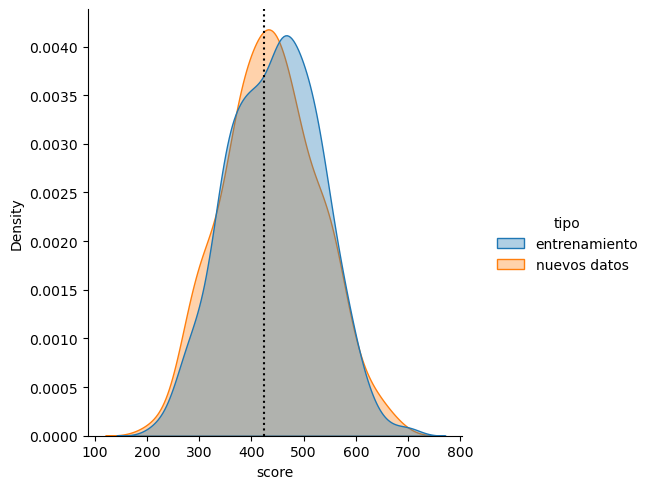

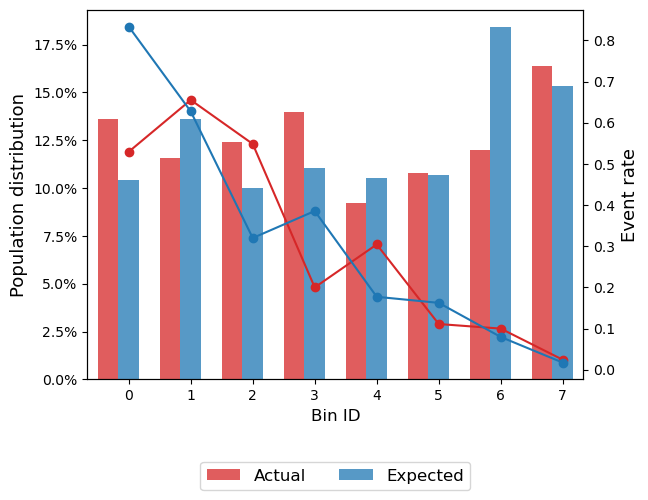

,Bin,Count A,Count E,Event rate A,Event rate E,statistic,p-value
0,"(-inf, 331.91)",34,78,0.529412,0.833333,11.398258,0.000735
1,"[331.91, 375.96)",29,102,0.655172,0.627451,0.074745,0.784550
2,"[375.96, 405.52)",31,75,0.548387,0.320000,4.823638,0.028072
3,"[405.52, 436.89)",35,83,0.200000,0.385542,3.830202,0.050337
4,"[436.89, 459.39)",23,79,0.304348,0.177215,1.761022,0.184497
5,"[459.39, 484.77)",27,80,0.111111,0.162500,0.419194,0.517340
6,"[484.77, 536.08)",30,138,0.100000,0.079710,0.132806,0.715540
7,"[536.08, inf)",41,115,0.024390,0.017391,0.078498,0.779343


In [108]:
# Supongamos que tenemos un conjunto de nuevos datos que hemos ido recopilando después de la puesta en producción del modelo,
# y queremos utilizar esos nuevos datos para saber si es necesario revisar el modelo o si por el contrario podemos seguir utilizándolo

# Como en la base de datos no disponemos de este tipo de datos voy a suponer simplemente que los datos de test son los nuevos datos,

dt_nuevosdatos= dt_test.copy() 


from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks,ScorecardMonitoring


# Valores nuevos
Y_nuevo = dt_nuevosdatos['y'].values
X_nuevo = dt_nuevosdatos.drop(columns=['y']) #todas menos la primera que es el ID y la variable y

# Valores de entrenamiento
Y = dt_train['y'].values
X = dt_train.drop(columns=['y']) #todas menos la variable y


# ¿se distibuyen igual las probabilidades esperadas?
score_train = tarjeta.score(X)
score_nuevo = tarjeta.score(X_nuevo)

datos_score_psi1=pd.DataFrame(np.transpose([score_train,Y]), columns=['score','Y'])
datos_score_psi1['tipo']='entrenamiento'

datos_score_psi2=pd.DataFrame(np.transpose([score_nuevo,Y_nuevo]), columns=['score','Y'])
datos_score_psi2['tipo']='nuevos datos'

datos_score_psi= pd.concat([datos_score_psi1,datos_score_psi2])
sns.displot(data=datos_score_psi, x='score', label="event", hue='tipo', alpha=0.35,kind="kde", fill=True,common_norm=False)
plt.axvline(Score_Corte, color='k', linestyle=":")




# Estimo el psi
# Defino la tarjeta a evalear
psi=ScorecardMonitoring(tarjeta, psi_method="cart",psi_min_bin_size=0.10, psi_n_bins=20)
#psi=ScorecardMonitoring(tarjeta, psi_method= "quantile", psi_n_bins=10)


psi.fit(X_actual=X_nuevo, y_actual=Y_nuevo, X_expected=X, y_expected=Y)

psi.psi_plot()
psi.psi_table()
psi.tests_table()


In [109]:
psi.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.0537 (No significant change)

         PSI bin  Count  Count (%)
    [0.00, 0.10)      8        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      2      0.250
    [0.05, 0.10)      1      0.125
    [0.10, 0.50)      1      0.125
    [0.50, 1.00)      4      0.500

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records     250          -       750            -
        Event records      75        0.3       225          0.3
    Non-event records     175        0.7       525          0.7

  Performance metrics

                 Metric   Actual  Expected  Diff A - E
     True positive rate 0.480000  0.564444   -0.084444
     True negative rate 0.862

In [110]:
psi.psi_variable_table(style="summary").sort_values('PSI')

,Variable,PSI
7,other.installment.plans,0.000047
6,other.debtors.or.guarantors,0.002435
8,present.employment.since,0.002666
1,credit.amount,0.005290
12,status.of.existing.checking.account,0.010448
2,credit.history,0.012226
9,property,0.012647
11,savings.account.and.bonds,0.014369
4,housing,0.015817
10,purpose,0.033417
